In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
from IPython.display import clear_output
#from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle

# Load and prepare dataset

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

In [6]:
amount_to_Cut = int(np.floor((np.ma.size(train_images,axis=0)/BATCH_SIZE))*BATCH_SIZE)

train_images = train_images[:amount_to_Cut,:,:]
train_labels = train_labels[:amount_to_Cut,:]


In [7]:
train_images = (train_images) / 256  # Normalize the images to [0, 1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.11111111, 0.11111111, 0.11111111, 0.        , 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
      dtype=float32)>

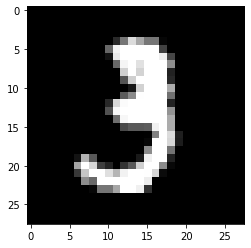

In [9]:
plt.plot()
plt.imshow(train_images[10,:, :], cmap='gray')
(tf.ones_like(train_labels[10])-train_labels[10])/9

In [10]:
# Batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_Output = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

# Create Models

### Generator

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(20,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

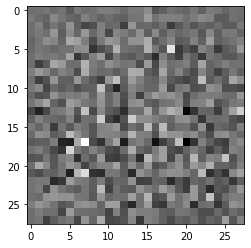

In [36]:
generator = make_generator_model()

noise = tf.random.normal([1, 20])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
noise.shape

TensorShape([1, 20])

### Discriminator

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(10))

    return model

In [37]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision.numpy())

[[ 0.03196542 -0.06906363  0.07070432  0.03862974 -0.05137143 -0.05140684
  -0.09130272  0.0247793   0.06596584  0.05488466]]


# Define Loss and Optimizers

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy_categorical = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cross_entropy_binary = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [17]:
def discriminator_loss(y_pred,y_real):
    return cross_entropy_categorical(y_real,y_pred)

In [18]:
def generator_loss(y_pred,y_real):
    return cross_entropy_categorical((tf.ones_like(y_real)-y_real),y_pred) #Add regularizer


In [19]:
def disc_evaluate(x,y):

  predictions = np.argmax(discriminator(x).numpy(),axis=1)
  
  return 1-((np.count_nonzero(np.argmax(y,axis=1)-predictions))/BATCH_SIZE)

In [20]:
def gen_norm_mean(x):
  flattened_x = np.reshape(x,(BATCH_SIZE,28*28))
  norm_calculated = np.linalg.norm(flattened_x,ord=2,axis=1)
  norm_mean = np.mean(norm_calculated)
  return norm_mean

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(1e-2)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# Define training loop

In [23]:
EPOCHS = 500
noise_dim = 20
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(train_X,train_Y):
    train_X = tf.cast(train_X, tf.float32)
    rand_in = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_noise = generator(rand_in, training=True)
      generated_noise = tf.squeeze(generated_noise)
      
      disc_output = discriminator(generated_noise+train_X, training=True)

      gen_loss = generator_loss(disc_output,train_Y)
      disc_loss = discriminator_loss(disc_output, train_Y)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss


In [25]:
def train(dataset, epochs):
  
  #Initialize arrays to save metrics (to plot)
  norm_evals = []
  disc_w_noise_accuracy = []
  disc_wo_noise_accuracy = []
  gen_loss_evals = []
  disc_loss_evals = []
  
  for epoch in range(epochs):
    print("epoch: "+ str(epoch))
    gen_loss_sum = 0
    disc_loss_sum = 0

    start = time.time()

    for x,y in dataset:
      gen_loss,disc_loss = train_step(x,y)

      gen_loss_sum = gen_loss_sum + gen_loss
      disc_loss_sum = disc_loss_sum + disc_loss

      clear_output()

      #discriminator evaluation: accuracy----------
      rand_in = tf.random.normal([BATCH_SIZE, noise_dim])
      x = tf.cast(x, tf.float32)

      generated_noise = generator(rand_in, training=False)
      generated_noise = tf.squeeze(generated_noise)

      norm_evals.append(gen_norm_mean(generated_noise))
      print("2nd order Norm: " + str(gen_norm_mean(generated_noise)))

      disc_wo_noise_accuracy.append(disc_evaluate(x,y))
      disc_w_noise_accuracy.append(disc_evaluate(x+generated_noise,y))
      print("Discriminator w/o Noise Accuracy: "+str(disc_evaluate(x,y)))
      print("Discriminator w/  Noise Accuracy: "+str(disc_evaluate(x+generated_noise,y)))
      #--------------------------------------------

      gen_loss_evals.append(gen_loss.numpy())
      disc_loss_evals.append(disc_loss.numpy())
      print("Generator Loss: "+ str(gen_loss.numpy()))
      print("Discriminator Loss: "+ str(disc_loss.numpy()))

      #generate_and_save_images(generator,seed)
      plot_metrics(norm_evals,disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals)
      

    #print("Generator Epoch Loss: "+ str(gen_loss_sum))
    #print("Discriminator Epoch Loss: "+ str(disc_loss_sum))
    #print("-----------------------------------")

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  #generate_and_save_images(generator,seed)


In [26]:
def generate_and_save_images(model, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

In [27]:
def plot_metrics(norm_evals,disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals):

  # Three subplots sharing both x/y axes
  f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=False,figsize=(12,8))

  ax1.plot(norm_evals,label="Norm")

  ax2.plot(disc_w_noise_accuracy,label="w Noise accuracy")
  ax2.plot(disc_wo_noise_accuracy,label="wo Noise accuracy")

  ax3.plot(gen_loss_evals,label="Gen Loss")
  ax4.plot(disc_loss_evals,label="Disc Loss")

  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()
  # Fine-tune figure; make subplots close to each other and hide x ticks for
  # all but bottom plot.
  f.subplots_adjust(hspace=0)
  plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

  

  plt.show()

# Train

2nd order Norm: 13.994156
Discriminator w/o Noise Accuracy: 0.10546875
Discriminator w/  Noise Accuracy: 0.06640625
Generator Loss: 66.251816
Discriminator Loss: 0.48223636


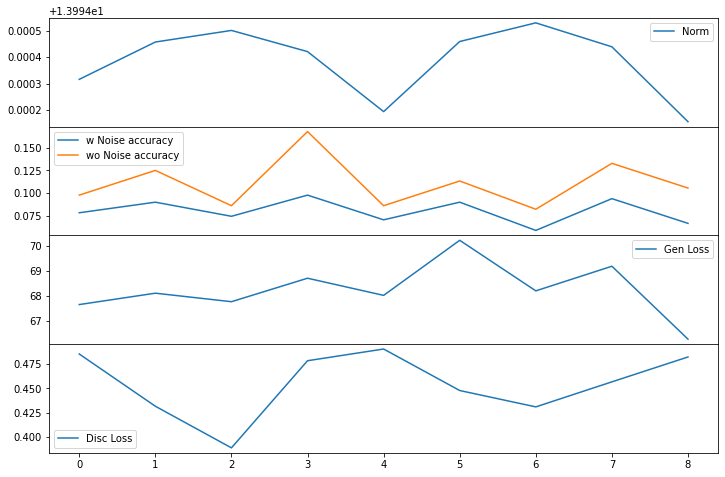

KeyboardInterrupt: ignored

In [40]:
train(dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

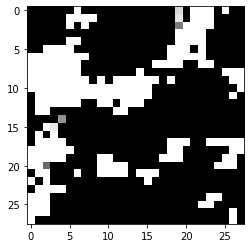

In [31]:
generated_image = generator(seed, training=False)

plt.imshow(generated_image[11, :, :, 0], cmap='gray')

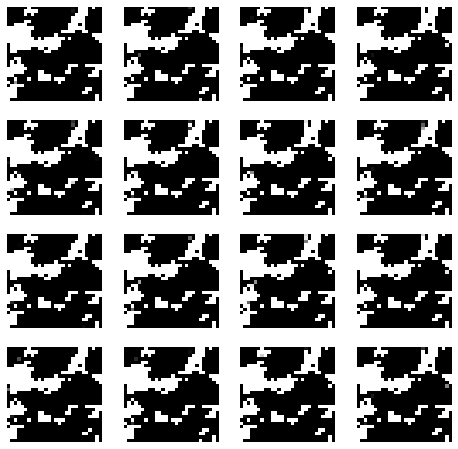

In [32]:
generate_and_save_images(generator, seed)